### Downloading

In [13]:
import os
import requests
import pandas as pd
import wfdb
import matplotlib.pyplot as plt

DATA_DIR = 'ctu_chb_data'
os.makedirs(DATA_DIR, exist_ok=True)

# Run wget command to download the data
# !wget -r -N -c -np -P {DATA_DIR} https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/

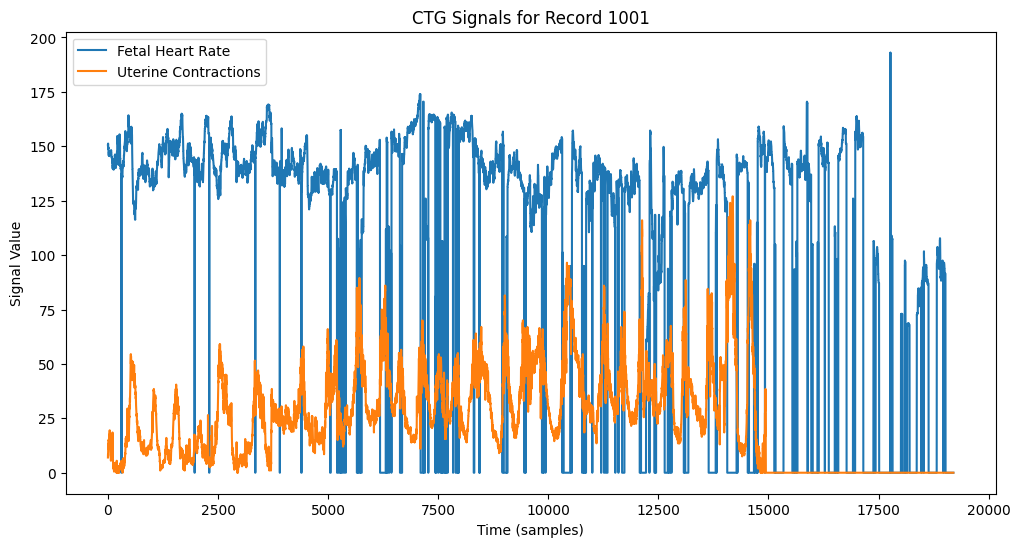

Record: 1001
Duration: 4800.0 seconds
Sampling frequency: 4 Hz
Signal names: ['FHR', 'UC']


In [14]:
# Initial data exploration
def explore_data():
    # Read the RECORDS file to get a list of all record numbers
    with open(os.path.join("ctu_chb_data", "RECORDS"), "r") as f:
        records = f.read().splitlines()

    # Select a sample record for exploration
    sample_record = records[0]

    # Read the signal data
    signal, fields = wfdb.rdsamp(os.path.join("ctu_chb_data", sample_record))

    # Plot the fetal heart rate and uterine contraction signals
    plt.figure(figsize=(12, 6))
    plt.plot(signal[:, 0], label='Fetal Heart Rate')
    plt.plot(signal[:, 1], label='Uterine Contractions')
    plt.xlabel('Time (samples)')
    plt.ylabel('Signal Value')
    plt.title(f'CTG Signals for Record {sample_record}')
    plt.legend()
    plt.show()

    # Print some basic information about the record
    print(f"Record: {sample_record}")
    print(f"Duration: {len(signal) / fields['fs']} seconds")
    print(f"Sampling frequency: {fields['fs']} Hz")
    print(f"Signal names: {fields['sig_name']}")

# Run the data exploration
explore_data()


### Visualizing

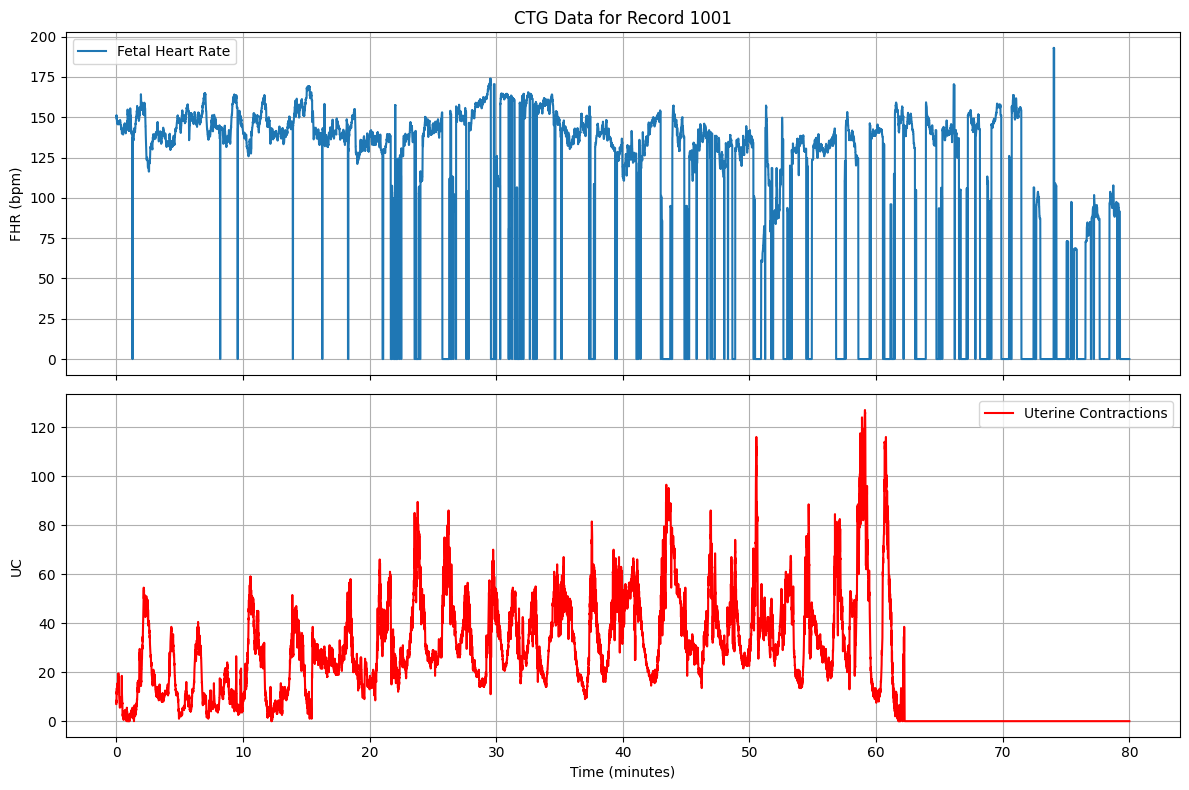

Record: 1001
Duration: 80.00 minutes
Sampling frequency: 4 Hz
Signal names: ['FHR', 'UC']


In [15]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

def visualize_ctg_data(record_id, data_dir='ctu_chb_data'):
    """
    Visualize CTG data from .dat and .hea files for a given record ID.
    
    Parameters:
    - record_id (str): The ID of the record to visualize.
    - data_dir (str): Directory where the data files are stored.
    
    Returns:
    None (displays a plot)
    """
    try:
        # Read the signal data
        record = wfdb.rdrecord(f"{data_dir}/{record_id}")
        
        # Extract signal data and time
        time = np.arange(len(record.p_signal)) / record.fs / 60  # Convert to minutes
        fhr = record.p_signal[:, 0]  # Fetal Heart Rate
        uc = record.p_signal[:, 1]   # Uterine Contractions
        
        # Create the plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot Fetal Heart Rate
        ax1.plot(time, fhr, label='Fetal Heart Rate')
        ax1.set_ylabel('FHR (bpm)')
        ax1.set_title(f'CTG Data for Record {record_id}')
        ax1.legend()
        ax1.grid(True)
        
        # Plot Uterine Contractions
        ax2.plot(time, uc, label='Uterine Contractions', color='red')
        ax2.set_xlabel('Time (minutes)')
        ax2.set_ylabel('UC')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print some additional information
        print(f"Record: {record_id}")
        print(f"Duration: {len(record.p_signal) / record.fs / 60:.2f} minutes")
        print(f"Sampling frequency: {record.fs} Hz")
        print(f"Signal names: {record.sig_name}")
        
    except Exception as e:
        print(f"Error processing record {record_id}: {str(e)}")

# Example usage
visualize_ctg_data('1001')  # Replace '1001' with any valid record ID


### Labeling

In [16]:
import pandas as pd
import numpy as np

def label_ctg_signals(data):
    def is_compromised(row):
        # Define thresholds for compromise indicators
        pH_threshold = 7.05
        apgar_threshold = 7
        be_threshold = -12
        
        # Check for indicators of compromise
        low_ph = row['pH'] < pH_threshold
        low_apgar = row['Apgar_score'] < apgar_threshold
        high_be = row['base_excess'] < be_threshold
        meconium = row['meconium_stained_fluid'] == 1
        nicu_admission = row['admission_to_NICU'] == 1
        oxygen_need = row['need_for_O2'] == 1
        seizures = row['seizures'] == 1
        
        # Label as compromised if any of the indicators are present
        return 1 if (low_ph or low_apgar or high_be or meconium or 
                     nicu_admission or oxygen_need or seizures) else 0
    
    # Apply the labeling function to each row
    data['fetal_compromise'] = data.apply(is_compromised, axis=1)
    
    return data

# Assuming 'ctg_data' is your DataFrame containing the CTG data
ctg_data = pd.read_csv('your_ctg_data.csv')
labeled_data = label_ctg_signals(ctg_data)

# Print summary of labeling
print(f"Total samples: {len(labeled_data)}")
print(f"Compromised samples: {labeled_data['fetal_compromise'].sum()}")
print(f"Healthy samples: {len(labeled_data) - labeled_data['fetal_compromise'].sum()}")


FileNotFoundError: [Errno 2] No such file or directory: 'your_ctg_data.csv'

In [17]:
import wfdb

def display_hea_file(record_name, data_dir='ctu_chb_data'):
    try:
        # Read the header file
        record = wfdb.rdheader(f"{data_dir}/{record_name}")
        display(record)
        
        print(f"Record Name: {record.record_name}")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Sample Frequency: {record.fs} Hz")
        print(f"Number of Samples: {record.sig_len}")
        
        print("\nSignal Information:")
        for i, (name, units) in enumerate(zip(record.sig_name, record.units)):
            print(f"  Signal {i+1}: {name} ({units})")
        
        print("\nComments:")
        for comment in record.comments:
            print(f"  {comment}")
        
    except Exception as e:
        print(f"Error reading header file: {str(e)}")

# Example usage
display_hea_file('1001')  # Replace '1001' with the desired record number


Record Name: 1001
Number of Signals: 2
Sample Frequency: 4 Hz
Number of Samples: 19200

Signal Information:
  Signal 1: FHR (bpm)
  Signal 2: UC (nd)

Comments:
  ----- Additional parameters for record 1001
  -- Outcome measures
  pH           7.14
  BDecf        8.14
  pCO2         7.7
  BE           -10.5
  Apgar1       6
  Apgar5       8
  -- !NotReadyYet! Neonatology outcome measures !NotReadyYet!
  NICU days    0
  Seizures     0
  HIE          0
  Intubation   0
  Main diag.   0
  Other diag.  0
  -- Fetus/Neonate descriptors
  Gest. weeks  37
  Weight(g)    2660
  Sex          2
  -- Maternal (risk-)factors
  Age          32
  Gravidity    1
  Parity       0
  Diabetes     1
  Hypertension 0
  Preeclampsia 0
  Liq. praecox 1
  Pyrexia      0
  Meconium     0
  -- Delivery descriptors
  Presentation 2
  Induced      0
  I.stage      232
  NoProgress   0
  CK/KP        0
  II.stage     20
  Deliv. type  1
  -- Signal information
  dbID         974204
  Rec. type    1
  Pos. II.st.

In [18]:
import wfdb

def label_sample(record_id, data_dir='ctu_chb_data'):
    try:
        # Read the header file
        record = wfdb.rdheader(f"{data_dir}/{record_id}")
        
        # Initialize variables
        pH = None
        apgar1 = None
        apgar5 = None
        nicu_days = None
        gest_weeks = None
        preeclampsia = None
        
        # Parse the comments to extract relevant information
        for comment in record.comments:
            if comment.startswith('pH'):
                pH = float(comment.split()[-1])
            elif comment.startswith('Apgar1'):
                apgar1 = int(comment.split()[-1])
            elif comment.startswith('Apgar5'):
                apgar5 = int(comment.split()[-1])
            elif comment.startswith('NICU days'):
                nicu_days = int(comment.split()[-1])
            elif comment.startswith('Gest. weeks'):
                gest_weeks = int(comment.split()[-1])
            elif comment.startswith('Preeclampsia'):
                preeclampsia = int(comment.split()[-1])
        
        # Check if the sample meets any of the compromise criteria
        is_compromised = (
            (pH is not None and pH < 7.2) or
            (apgar1 is not None and apgar1 < 7) or
            (apgar5 is not None and apgar5 < 7) or
            (nicu_days is not None and nicu_days > 0) or
            (gest_weeks is not None and gest_weeks < 37) or
            (preeclampsia is not None and preeclampsia == 1)
        )
        
        label = 1 if is_compromised else 0
        
        return label, {
            'pH': pH,
            'Apgar1': apgar1,
            'Apgar5': apgar5,
            'NICU_days': nicu_days,
            'Gestational_weeks': gest_weeks,
            'Preeclampsia': preeclampsia
        }
    
    except Exception as e:
        print(f"Error processing record {record_id}: {str(e)}")
        return None, None

# Example usage
record_id = '1001'  # Replace with the desired record ID
label, indicators = label_sample(record_id)

if label is not None:
    print(f"Record {record_id}:")
    print(f"Label: {label} ({'Compromised' if label == 1 else 'Not Compromised'})")
    print("Indicators:")
    for key, value in indicators.items():
        print(f"  {key}: {value}")
else:
    print(f"Failed to process record {record_id}")


Record 1001:
Label: 1 (Compromised)
Indicators:
  pH: 7.14
  Apgar1: 6
  Apgar5: 8
  NICU_days: 0
  Gestational_weeks: 37
  Preeclampsia: 0


In [ ]:
import os
import csv
import wfdb
from tqdm import tqdm

def label_all_samples(data_dir='ctu_chb_data', output_file='labels.csv'):
    def label_sample(record_id):
        try:
            record = wfdb.rdheader(os.path.join(data_dir, record_id))
            
            pH = apgar1 = apgar5 = nicu_days = gest_weeks = preeclampsia = None
            
            for comment in record.comments:
                if comment.startswith('pH'):
                    pH = float(comment.split()[-1])
                elif comment.startswith('Apgar1'):
                    apgar1 = int(comment.split()[-1])
                elif comment.startswith('Apgar5'):
                    apgar5 = int(comment.split()[-1])
                elif comment.startswith('NICU days'):
                    nicu_days = int(comment.split()[-1])
                elif comment.startswith('Gest. weeks'):
                    gest_weeks = int(comment.split()[-1])
                elif comment.startswith('Preeclampsia'):
                    preeclampsia = int(comment.split()[-1])
            
            is_compromised = (
                (pH is not None and pH < 7.2) or
                (apgar1 is not None and apgar1 < 7) or
                (apgar5 is not None and apgar5 < 7) or
                (nicu_days is not None and nicu_days > 0) or
                (gest_weeks is not None and gest_weeks < 37) #or
                (preeclampsia is not None and preeclampsia == 1)
            )
            
            return 1 if is_compromised else 0
        
        except Exception as e:
            print(f"Error processing record {record_id}: {str(e)}")
            return None

    # Get all .hea files in the directory
    hea_files = [f[:-4] for f in os.listdir(data_dir) if f.endswith('.hea')]
    
    # Sort the files to ensure consistent ordering
    hea_files.sort()
    
    # Prepare the output data
    output_data = []
    
    # Process each .hea file with a progress bar
    for record_id in tqdm(hea_files, desc="Processing samples"):
        label = label_sample(record_id)
        if label is not None:
            output_data.append([record_id, label])
    
    # Write the output to a CSV file
    with open(output_file, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['sample', 'label'])  # Write header
        csv_writer.writerows(output_data)
    
    print(f"Labeling complete. Output written to {output_file}")

# Example usage
label_all_samples()


Processing samples: 100%|█| 552/552 [00:00<00:00, 4335.0

Labeling complete. Output written to labels.csv


In [27]:
labels = pd.read_csv("labels.csv")
labels.label.value_counts()

label
0    353
1    199
Name: count, dtype: int64

### Cohort Characterization

Processing samples: 100%|█| 552/552 [00:00<00:00, 3486.6


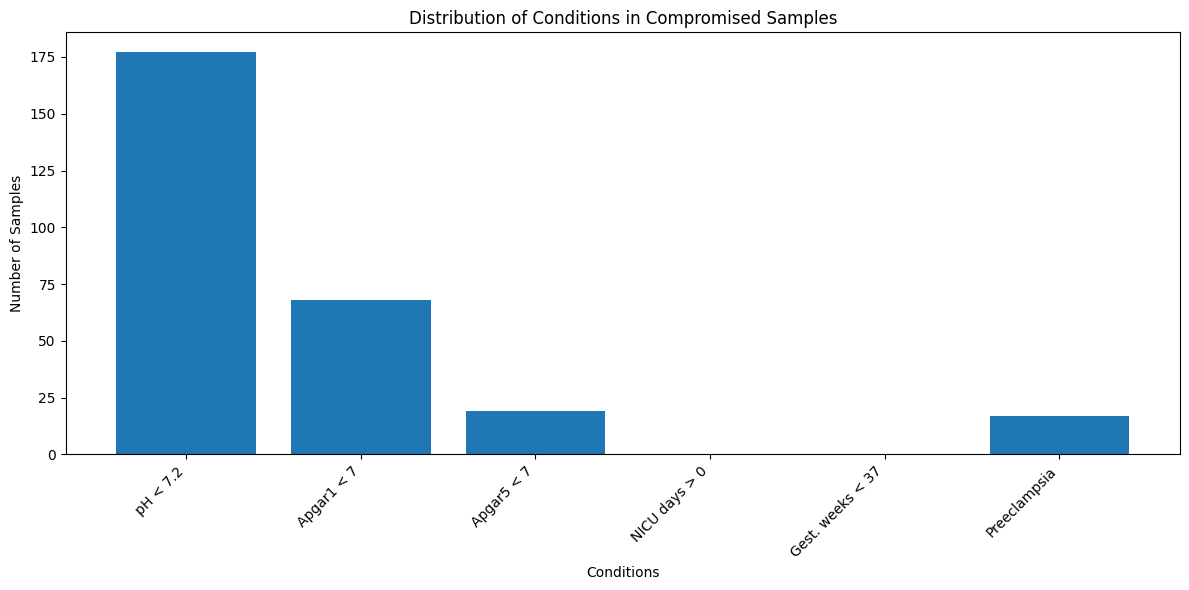

Total samples: 552
Compromised samples: 208
Percentage of compromised samples: 37.68%

Condition counts:
pH < 7.2: 177
Apgar1 < 7: 68
Apgar5 < 7: 19
NICU days > 0: 0
Gest. weeks < 37: 0
Preeclampsia: 17


In [28]:
import os
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_cohorts(data_dir='ctu_chb_data'):
    conditions = {
        'pH < 7.2': 0,
        'Apgar1 < 7': 0,
        'Apgar5 < 7': 0,
        'NICU days > 0': 0,
        'Gest. weeks < 37': 0,
        'Preeclampsia': 0
    }
    
    total_samples = 0
    compromised_samples = 0

    hea_files = [f for f in os.listdir(data_dir) if f.endswith('.hea')]
    
    for hea_file in tqdm(hea_files, desc="Processing samples"):
        record_id = hea_file[:-4]
        record = wfdb.rdheader(os.path.join(data_dir, record_id))
        
        pH = apgar1 = apgar5 = nicu_days = gest_weeks = preeclampsia = None
        
        for comment in record.comments:
            if comment.startswith('pH'):
                pH = float(comment.split()[-1])
            elif comment.startswith('Apgar1'):
                apgar1 = int(comment.split()[-1])
            elif comment.startswith('Apgar5'):
                apgar5 = int(comment.split()[-1])
            elif comment.startswith('NICU days'):
                nicu_days = int(comment.split()[-1])
            elif comment.startswith('Gest. weeks'):
                gest_weeks = int(comment.split()[-1])
            elif comment.startswith('Preeclampsia'):
                preeclampsia = int(comment.split()[-1])
        
        total_samples += 1
        is_compromised = False
        
        if pH is not None and pH < 7.2:
            conditions['pH < 7.2'] += 1
            is_compromised = True
        if apgar1 is not None and apgar1 < 7:
            conditions['Apgar1 < 7'] += 1
            is_compromised = True
        if apgar5 is not None and apgar5 < 7:
            conditions['Apgar5 < 7'] += 1
            is_compromised = True
        if nicu_days is not None and nicu_days > 0:
            conditions['NICU days > 0'] += 1
            is_compromised = True
        if gest_weeks is not None and gest_weeks < 37:
            conditions['Gest. weeks < 37'] += 1
            is_compromised = True
        if preeclampsia is not None and preeclampsia == 1:
            conditions['Preeclampsia'] += 1
            is_compromised = True
        
        if is_compromised:
            compromised_samples += 1
    
    return conditions, total_samples, compromised_samples

# Run the analysis
conditions, total_samples, compromised_samples = analyze_cohorts()

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(conditions.keys(), conditions.values())
plt.title('Distribution of Conditions in Compromised Samples')
plt.xlabel('Conditions')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary
print(f"Total samples: {total_samples}")
print(f"Compromised samples: {compromised_samples}")
print(f"Percentage of compromised samples: {compromised_samples/total_samples*100:.2f}%")
print("\nCondition counts:")
for condition, count in conditions.items():
    print(f"{condition}: {count}")
